In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency, zscore, shapiro, ttest_ind
pd.set_option('display.max_columns', None)

In [31]:
df_raw = pd.read_csv(r"/Users/muayadhilamia/Desktop/Ironhack/Week-5/Project/week5_6_project/data/cleaned/df_cleand_raw_m.csv")

                    --- Cleaning and sorting

In [32]:

# making copy to avoid errors 
df = df_raw.copy()

# deleting "Unnamed" column 
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# dropping nulls in "Variation"
df = df[df['Variation'].notna() & (df['Variation'] != "")]

# columns i want them to be intger 
int_cols = [
    'client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 
    'clnt_age', 'num_accts', 'calls_6_mnth', 'logons_6_mnth',
    'num_steps', 'num_visits', 'total_steps', 'step_repeat_count', 'step_diff', "time_from_prev_step"
]
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# making "bal" float and round it 
if 'bal' in df.columns:
    df['bal'] = pd.to_numeric(df['bal'], errors='coerce').round(2)

# fixing date_time column 
if 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# dropping duplicates 
df = df.drop_duplicates()


# sorting by client, visit and date_time
df = df.sort_values(
    by=['client_id', 'visit_id', 'date_time'],
    ascending=[True, True, True]
)


In [ ]:
df.head

In [41]:


# ---------- 1. KEEP LAST STEP PER VISIT ----------
df_last_visit = df.drop_duplicates(subset="visit_id", keep="last")

# ---------- 2. COMPLETION RATE ----------
# completion rate = proportion of visits that were completed
completion_rate = df_last_visit.groupby('Variation')['completed'].mean()

# ---------- 3. ERROR RATE ----------
# count how many errors per visit_id
errors_per_visit = (
    df.groupby(['visit_id', 'Variation'])['error_flag']
    .sum()
    .reset_index(name='error_count')
)

# create a flag if visit had at least one error
errors_per_visit['has_error'] = errors_per_visit['error_count'] > 0

# calculate average error rate per Variation
error_rate = errors_per_visit.groupby('Variation')['has_error'].mean()

# ---------- 4. PRINT KPI SUMMARY ----------
print("Completion Rate per group:\n", completion_rate)
print("\nError Rate per group:\n", error_rate)

print("*" * 50)

# ---------- 5. SPLIT GROUPS FOR HYPOTHESIS TEST ----------
test_group_last = df_last_visit[df_last_visit['Variation'] == 'Test']
control_group_last = df_last_visit[df_last_visit['Variation'] == 'Control']

test_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Test']
control_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Control']

# ---------- 6. HYPOTHESIS TESTING ----------
# Completion rate hypothesis test
# H0: mean(Test.completed) <= mean(Control.completed)
# H1: mean(Test.completed) > mean(Control.completed)
t_stat_comp, p_val_comp = ttest_ind(
    test_group_last['completed'],
    control_group_last['completed'],
    alternative='greater'
)

print("Completion Rate - T-statistic:", t_stat_comp)
print("Completion Rate - P-value:", p_val_comp)

# Error rate hypothesis test
# H0: mean(Test.has_error) >= mean(Control.has_error)
# H1: mean(Test.has_error) < mean(Control.has_error)
t_stat_err, p_val_err = ttest_ind(
    test_group_err['has_error'],
    control_group_err['has_error'],
    alternative='less'
)

print("\nError Rate - T-statistic:", t_stat_err)
print("Error Rate - P-value:", p_val_err)

print("*" * 50)

# ---------- 7. DECISION MAKING ----------
alpha = 0.05  # significance level

# Completion rate decision
if p_val_comp < alpha:
    print("\n✅ Test group has significantly higher completion rate than Control.")
else:
    print("\n❌ No statistical evidence that Test performed better in completion rate.")

# Error rate decision
if p_val_err < alpha:
    print("✅ Test group has significantly lower error rate than Control.")
else:
    print("❌ No statistical evidence that Test had fewer errors than Control.")

Completion Rate per group:
 Variation
Control    0.498257
Test       0.584815
Name: completed, dtype: float64

Error Rate per group:
 Variation
Control    0.206126
Test       0.271192
Name: has_error, dtype: float64
**************************************************
Completion Rate - T-statistic: 22.889178046862124
Completion Rate - P-value: 8.016661801897825e-116

Error Rate - T-statistic: 20.03506092717574
Error Rate - P-value: 1.0
**************************************************

✅ Test group has significantly higher completion rate than Control.
❌ No statistical evidence that Test had fewer errors than Control.


In [ ]:


# ---------- Step 1: Compute step durations ----------
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df = df.sort_values(by=['visit_id', 'process_step'])

# Calculate duration between steps (in seconds)
df['step_duration'] = (
    df.groupby('visit_id')['date_time']
    .diff()
    .dt.total_seconds()
)

# Remove first step (NaN duration)
df_steps = df.dropna(subset=['step_duration']).copy()

# ---------- Step 2: Remove outliers via IQR ----------
def remove_outliers_iqr(sub_df, col):
    """Remove outliers using IQR rule for one group."""
    Q1 = sub_df[col].quantile(0.25)
    Q3 = sub_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return sub_df[(sub_df[col] >= lower) & (sub_df[col] <= upper)]

# Apply outlier removal for each Variation and process_step
df_steps_no_outliers = (
    df_steps
    .groupby(['Variation', 'process_step'], group_keys=False)
    .apply(lambda x: remove_outliers_iqr(x, 'step_duration'))
)

print(f"Removed {len(df_steps) - len(df_steps_no_outliers)} outliers using IQR filter.")

# ---------- Step 3: Average time per step ----------
avg_step_time = (
    df_steps_no_outliers
    .groupby(['Variation', 'process_step'])['step_duration']
    .mean()
    .reset_index()
)

print("\nAverage step duration (seconds, after removing outliers):")
print(avg_step_time)

# ---------- Step 4: Hypothesis testing ----------
results = []

for step in sorted(df_steps_no_outliers['process_step'].unique()):
    # Subset data
    test_times = df_steps_no_outliers[
        (df_steps_no_outliers['Variation'] == 'Test') &
        (df_steps_no_outliers['process_step'] == step)
    ]['step_duration']

    control_times = df_steps_no_outliers[
        (df_steps_no_outliers['Variation'] == 'Control') &
        (df_steps_no_outliers['process_step'] == step)
    ]['step_duration']

    # Run one-tailed t-test (expect Test to be faster)
    t_stat, p_val = ttest_ind(test_times, control_times, alternative='less')

    results.append({
        'process_step': step,
        't_stat': t_stat,
        'p_value': p_val,
        'test_mean': test_times.mean(),
        'control_mean': control_times.mean(),
    })

results_df = pd.DataFrame(results)
alpha = 0.05
results_df['significant'] = results_df['p_value'] < alpha

print("\nStep-wise duration test results (after removing outliers):")
print(results_df)

Removed 47040 outliers using IQR filter.

Average step duration (seconds, after removing outliers):
  Variation  process_step  step_duration
0   Control             1     112.578307
1   Control             2      28.034929
2   Control             3      34.359256
3   Control             4      72.055138
4   Control             5      85.126034
5      Test             1     121.427855
6      Test             2      27.101874
7      Test             3      33.563688
8      Test             4      77.039203
9      Test             5      69.535524

Step-wise duration test results (after removing outliers):
   process_step     t_stat        p_value   test_mean  control_mean  \
0             1   6.380087   1.000000e+00  121.427855    112.578307   
1             2  -2.644617   4.090509e-03   27.101874     28.034929   
2             3  -2.553255   5.337709e-03   33.563688     34.359256   
3             4   8.858560   1.000000e+00   77.039203     72.055138   
4             5 -24.025811  8.2456

/var/folders/lt/yxd_bdjs4fn9bd90z539wlsm0000gn/T/ipykernel_7456/3248990312.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: remove_outliers_iqr(x, 'step_duration'))


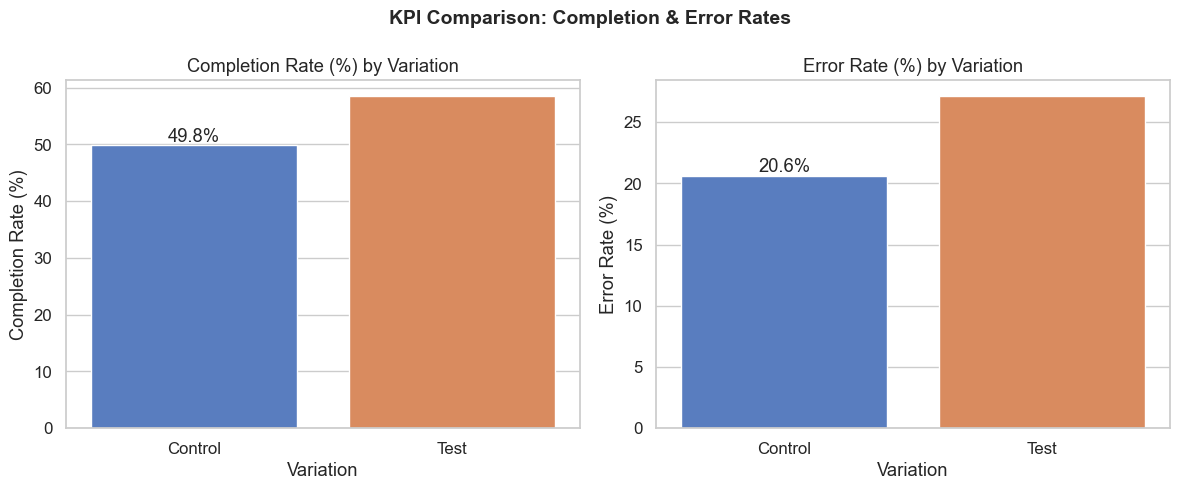

/var/folders/lt/yxd_bdjs4fn9bd90z539wlsm0000gn/T/ipykernel_7456/1903219546.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


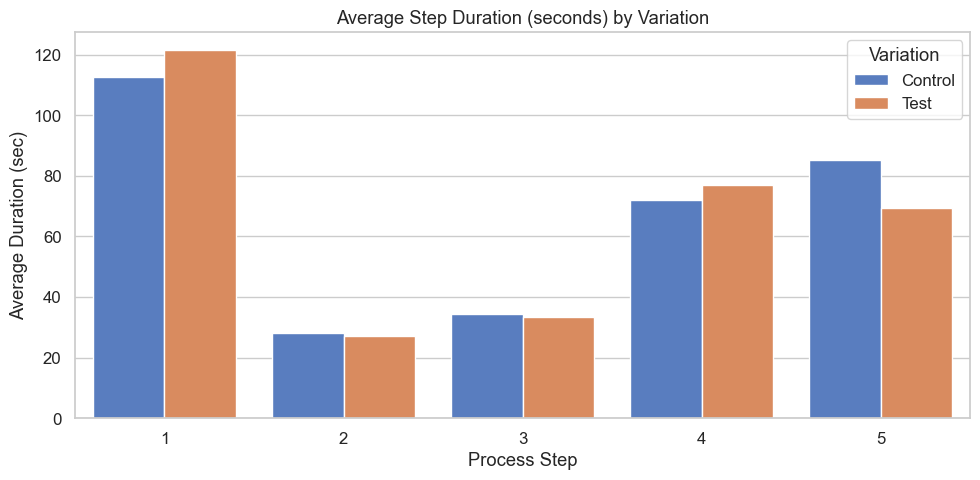

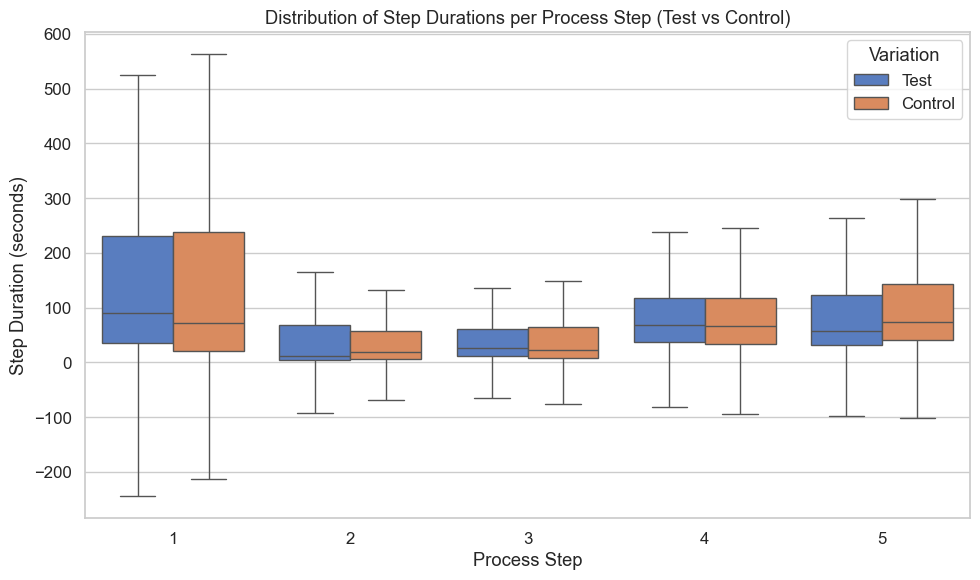

/var/folders/lt/yxd_bdjs4fn9bd90z539wlsm0000gn/T/ipykernel_7456/1903219546.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


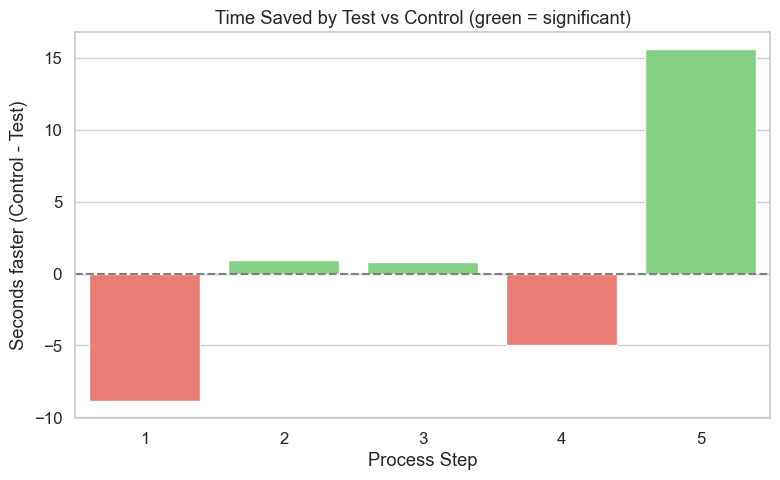

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ---------- 1️⃣ COMPLETION & ERROR RATE BAR CHART ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Completion Rate plot
sns.barplot(
    x=completion_rate.index,
    y=completion_rate.values * 100,
    ax=ax[0],
    hue=completion_rate.index,
    legend=False
)
ax[0].set_title("Completion Rate (%) by Variation")
ax[0].set_xlabel("Variation")
ax[0].set_ylabel("Completion Rate (%)")
ax[0].bar_label(ax[0].containers[0], fmt="%.1f%%")

# Error Rate plot
sns.barplot(
    x=error_rate.index,
    y=error_rate.values * 100,
    ax=ax[1],
    hue=error_rate.index,
    legend=False
)
ax[1].set_title("Error Rate (%) by Variation")
ax[1].set_xlabel("Variation")
ax[1].set_ylabel("Error Rate (%)")
ax[1].bar_label(ax[1].containers[0], fmt="%.1f%%")

plt.suptitle("KPI Comparison: Completion & Error Rates", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# ---------- 2️⃣ STEP DURATION BAR CHART ----------
plt.figure(figsize=(10, 5))
sns.barplot(
    data=avg_step_time,
    x="process_step",
    y="step_duration",
    hue="Variation",
    ci=None
)
plt.title("Average Step Duration (seconds) by Variation")
plt.xlabel("Process Step")
plt.ylabel("Average Duration (sec)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

# ---------- 3️⃣ DISTRIBUTION (OPTIONAL BUT GREAT FOR PRESENTATION) ----------
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_steps,
    x="process_step",
    y="step_duration",
    hue="Variation",
    showfliers=False  # hides extreme outliers for readability
)
plt.title("Distribution of Step Durations per Process Step (Test vs Control)")
plt.xlabel("Process Step")
plt.ylabel("Step Duration (seconds)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

# ---------- 4️⃣ SIGNIFICANCE HIGHLIGHT (OPTIONAL) ----------
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x="process_step",
    y=(results_df['control_mean'] - results_df['test_mean']),
    palette=["#ff6961" if not sig else "#77dd77" for sig in results_df['significant']]
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Time Saved by Test vs Control (green = significant)")
plt.xlabel("Process Step")
plt.ylabel("Seconds faster (Control - Test)")
plt.tight_layout()
plt.show()